# Autoencoder Architectures for Image Reconstruction

## Introduction

We compared of two different autoencoder architectures for image reconstruction tasks: a standard Convolutional Neural Network (CNN) autoencoder and a ResNet-based autoencoder without skip layers, so forcing the net to train based Conv + batch normalization

In [1]:
# Import general modules

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [17]:

# Load preprocessed images
X = np.load("/content/drive/MyDrive/Diego/deep_learning/X_images.npy")
y = np.load("/content/drive/MyDrive/Diego/deep_learning/y_labels.npy")

# Split both images and labels together
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # stratify keeps label distribution

print('Training data shapes: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Testing data shapes: X=%s, y=%s' % (x_test.shape, y_test.shape))

# Params used globally
IMG_SIZE = 256
BATCH_SIZE = 64
VAL_SPLIT = 0.1
EPOCHS = 50

X.shape, y.shape

Training data shapes: X=(2324, 256, 256, 3), y=(2324,)
Testing data shapes: X=(582, 256, 256, 3), y=(582,)


((2906, 256, 256, 3), (2906,))

In [11]:
X.max(), X.min()

(np.float32(1.0), np.float32(0.0))

In [4]:
n = 10
test_samples = x_test[:n]

## Loss Function: Mean Squared Error (MSE)

### Why MSE for Autoencoders?

For both autoencoder architectures, we use **Mean Squared Error (MSE)** as the loss function. The loss measures the average squared difference between the original and reconstructed pixel values. It largely penalizes larger reconstruction errors, encouraging the model to avoid significant distortions in the output images. Quality is not the best, but the shape and the core of the image looks good. 


## CNN Autoencoder 


- Uses Conv2D layers with stride=2 for downsampling
- Dimension reduces but channels increase: 3 → 32 → 64 → 128 → 256 
- The latent space is multidimensional, and not flattened
- the latents space is: 16×16×32
- Decoder is a mirror of the encoder, and output is sigmoid
- Output is signmoid even tho we have multiple clases because we want to predict the pixel intensity not the class


In [13]:
# CNN Autoencoder
def build_cnn_autoencoder():
    encoder_input = layers.Input(shape=(256, 256, 3))

    # Encoder -
    x = layers.Conv2D(32, 3, padding='same')(encoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)

    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)

    # latent space (16, 16, 32)
    latent = layers.Conv2D(32, 3, activation='relu', padding='same', name='latent')(x)

    # Decoder -
    x = layers.UpSampling2D(2)(latent)
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(3, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    decoder_output = layers.Activation('sigmoid')(x)

    autoencoder = Model(encoder_input, decoder_output, name='cnn_autoencoder')
    return autoencoder

cnn_ae = build_cnn_autoencoder()
cnn_ae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
cnn_ae.summary()


Model: "cnn_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Conv2D)                 │ (None, 16, 16, 32)     │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 928,175 (3.54 MB)

 Trainable params: 926,249 (3.53 MB)

 Non-trainable params: 1,926 (7.52 KB)

In [19]:
history_cnn = cnn_ae.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                         validation_split=0.1, verbose=1)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0697 - val_loss: 0.0671
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0684 - val_loss: 0.0662
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0664 - val_loss: 0.0649
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0658 - val_loss: 0.0644
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0634 - val_loss: 0.0623
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0624 - val_loss: 0.0614
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0617 - val_loss: 0.0576
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0611 - val_loss: 0.0601
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0581 - val_loss: 0.0574
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0573 - val_loss: 0.0576
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0558 - val_loss: 0.0543
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 

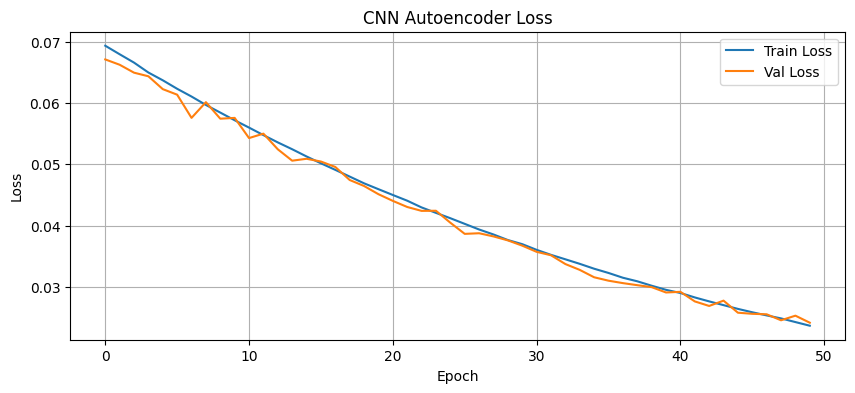

In [20]:
# CNN loss
plt.figure(figsize=(10, 4))
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('CNN Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


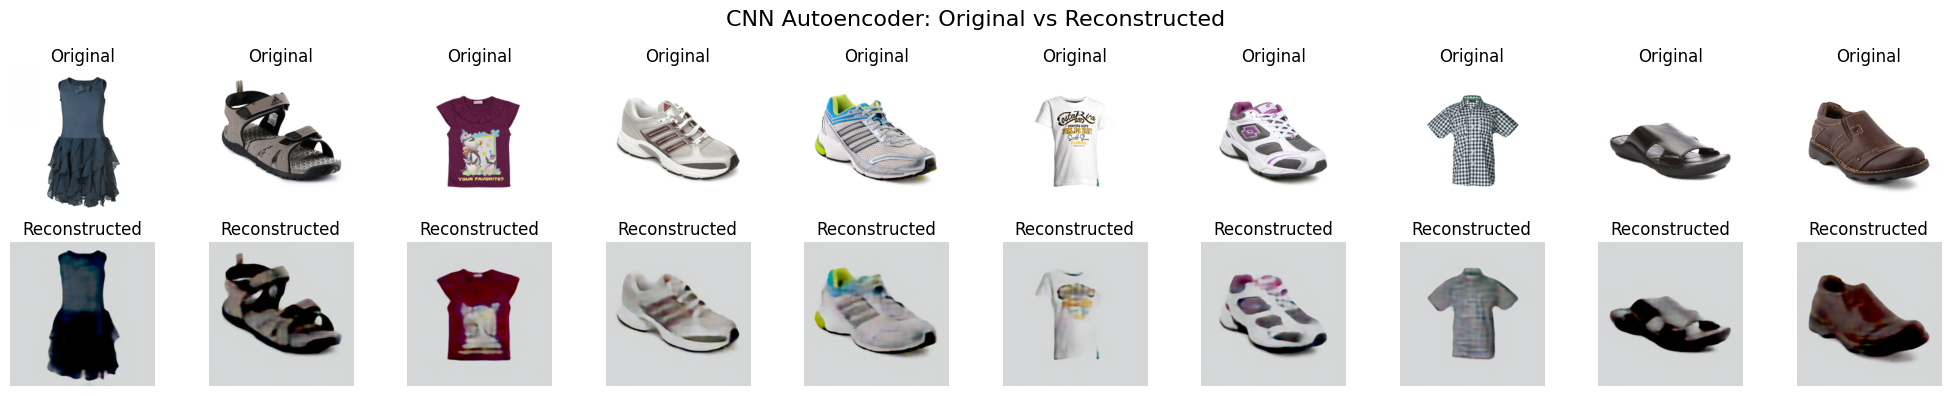

In [21]:
# CNN reconstructions
reconstructed = cnn_ae.predict(test_samples)

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_samples[i])
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i])
    plt.title("Reconstructed")
    plt.axis('off')
plt.suptitle('CNN Autoencoder: Original vs Reconstructed', fontsize=16)
plt.tight_layout()
plt.show()

## ResNet-Lookalike 


- Similar downsampling strategy as CNN autoencoder
- Features maps are created for each size of the image, which strongly helps the reconstruction
- By not having skip connections, low-level details are not kept
- Latent space is flattened


In [22]:
# Resnet lookalike autoencoder
def build_resnet_autoencoder():
    encoder_input = layers.Input(shape=(256, 256, 3))

    # Encoder - double conv per stage
    x = layers.Conv2D(32, 3, padding='same')(encoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)

    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)

    x = layers.Flatten()(x)
    latent = layers.Dense(64, activation='relu', name='latent')(x)


    x = layers.Dense(16*16*256, activation='relu')(latent)
    x = layers.Reshape((16, 16, 256))(x)

    # Decoder -
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)


    x = layers.Conv2D(3, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    decoder_output = layers.Activation('sigmoid')(x)

    autoencoder = Model(encoder_input, decoder_output, name='resnet_autoencoder')
    return autoencoder

resnet_ae = build_resnet_autoencoder()
resnet_ae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
resnet_ae.summary()

Model: "resnet_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 32, 32, 256)    │             

 Total params: 10,786,383 (41.15 MB)

 Trainable params: 10,783,177 (41.13 MB)

 Non-trainable params: 3,206 (12.52 KB)

In [27]:
history_resnet = resnet_ae.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                         validation_split=0.1, verbose=1)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 0.1091 - val_loss: 0.1095
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.1069 - val_loss: 0.1086
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.1059 - val_loss: 0.1066
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.1057 - val_loss: 0.1044
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.1047 - val_loss: 0.1034
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.1034 - val_loss: 0.1056
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.1042 - val_loss: 0.1027
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 0.1033 - val_loss: 0.1013
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.1036 - val_loss: 0.1025
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.1030 - val_loss: 0.1013
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.1023 - val_loss: 0.1014
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step -

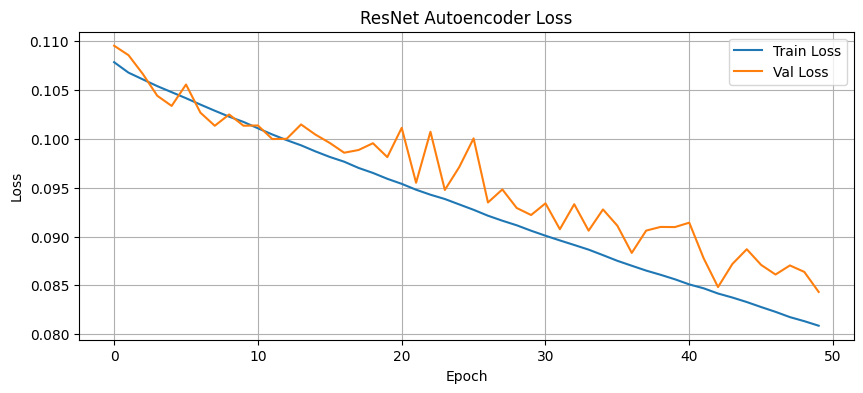

In [28]:
# ResNet loss
plt.figure(figsize=(10, 4))
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.title('ResNet Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


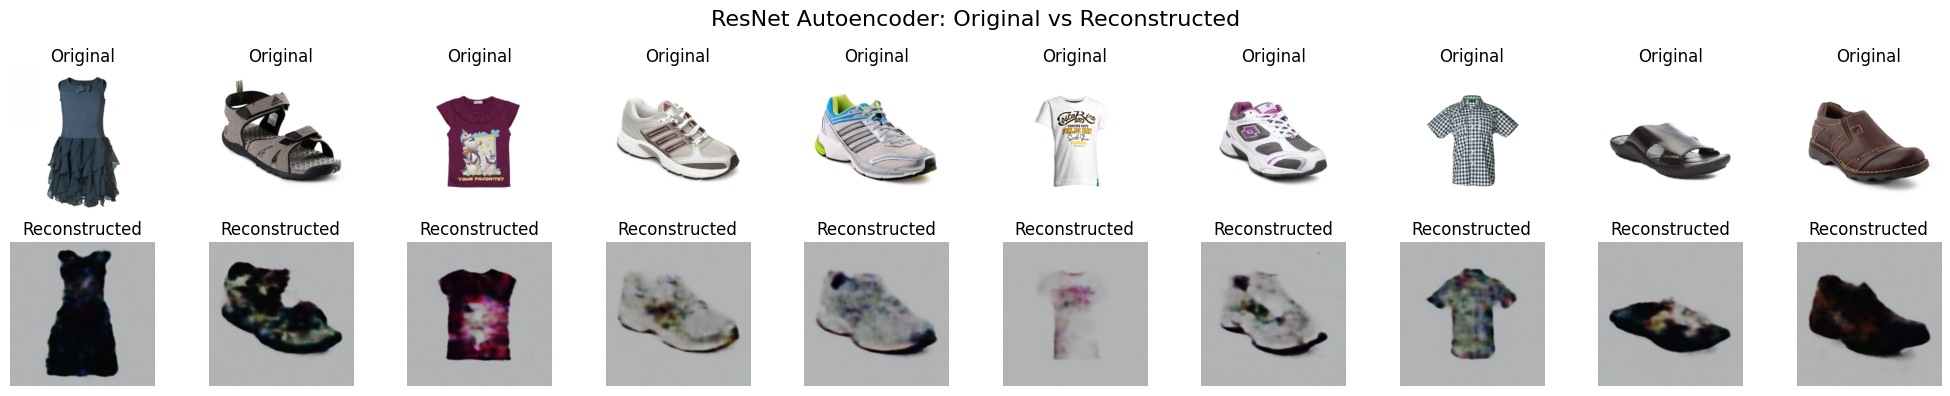

In [29]:
# ResNet reconstructions
reconstructed = resnet_ae.predict(test_samples)

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_samples[i])
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i])
    plt.title("Reconstructed")
    plt.axis('off')
plt.suptitle('ResNet Autoencoder: Original vs Reconstructed', fontsize=16)
plt.tight_layout()
plt.show()

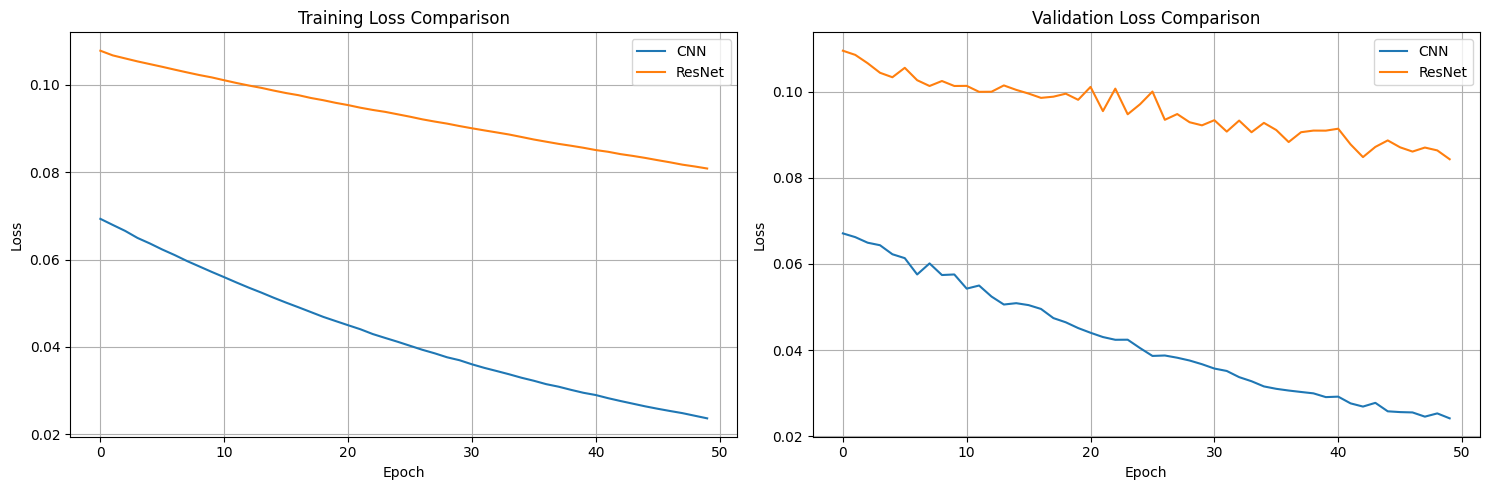


Final Validation Loss:
CNN: 0.024142
ResNet: 0.084329


In [30]:
# Compare all models
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='CNN')
plt.plot(history_resnet.history['loss'], label='ResNet')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['val_loss'], label='CNN')
plt.plot(history_resnet.history['val_loss'], label='ResNet')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nFinal Validation Loss:")
print(f"CNN: {history_cnn.history['val_loss'][-1]:.6f}")
print(f"ResNet: {history_resnet.history['val_loss'][-1]:.6f}")

## Conclusion

Based on the training results and validation loss metrics:

- **Final Validation Loss**:
  - CNN Autoencoder: Lower final validation loss indicates better pixel-wise reconstruction, with few parameters. Small LR made the net to still have a lot of potential improving. 
  - ResNet Autoencoder: ResNet get benefited by skip connections, but if we get rid of them, they dont outperform other simple nets.
